# Training our Fruit Classifer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


In [2]:
num_classes = 81
img_rows, img_cols = 32, 32
batch_size = 32

In [3]:
train_data_dir = 'fruits-360/train'
validation_data_dir = 'fruits-360/validation'

In [4]:
# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

In [5]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 41322 images belonging to 81 classes.


In [7]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 13877 images belonging to 81 classes.


### Let's define our model

In [8]:
def convnet():
    model = Sequential([
    # Padding = 'same'  results in padding the input such that
    # the output has the same length as the original input
    Conv2D(32, (3, 3), padding='same',activation='relu',input_shape= (img_rows, img_cols, 3)),
    Conv2D(32, (3, 3),activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
    ])
    return model

In [9]:
model = convnet()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [10]:
checkpoint = ModelCheckpoint("fruit-classifier-cnn-model_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)
# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

In [11]:
model.compile(loss = 'categorical_crossentropy',optimizer = Adam(lr = 0.001),metrics = ['accuracy'])

In [12]:
nb_train_samples = 41322
nb_validation_samples = 13877
epochs = 5

In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
1291/1291 [==============================] - 74s 57ms/step - loss: 1.9903 - acc: 0.3885 - val_loss: 0.5492 - val_acc: 0.8213

Epoch 00001: val_loss improved from inf to 0.54915, saving model to fruit-classifier-cnn-model_1.h5
Epoch 2/5
1291/1291 [==============================] - 63s 49ms/step - loss: 0.6219 - acc: 0.7831 - val_loss: 0.3298 - val_acc: 0.8656

Epoch 00002: val_loss improved from 0.54915 to 0.32980, saving model to fruit-classifier-cnn-model_1.h5
Epoch 3/5
1291/1291 [==============================] - 64s 49ms/step - loss: 0.4033 - acc: 0.8594 - val_loss: 0.1682 - val_acc: 0.9442

Epoch 00003: val_loss improved from 0.32980 to 0.16818, saving model to fruit-classifier-cnn-model_1.h5
Epoch 4/5
1291/1291 [==============================] - 63s 49ms/step - loss: 0.3251 - acc: 0.8854 - val_loss: 0.1337 - val_acc: 0.9469

Epoch 00004: val_loss improved from 0.16818 to 0.13374, saving model to fruit-classifier-cnn-model_1.h5
Epoch 5/5
1291/1291 [=======================

In [14]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

434/434 [==============================] - 6s 15ms/step

Test result: 93.133 loss: 0.198


In [15]:
model.save('fruit-classifier-cnn-model.h5')

In [16]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)

In [17]:
y_pred_label = np.argmax(y_pred, axis=1)

### Confusion Matrix

In [18]:
#Confusion Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred_label))
print('Classification Report')
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Confusion Matrix
[[ 66   0   0 ...   0   0  85]
 [  2  78   0 ...   0   0   0]
 [  0  85  79 ...   0   0   0]
 ...
 [  0   0   0 ...  79   0   0]
 [  0   0   0 ...  85  42   0]
 [  0   0   0 ...   0  85 164]]
Classification Report
                     precision    recall  f1-score   support

     Apple Braeburn       0.38      0.40      0.39       164
     Apple Golden 1       0.48      0.48      0.48       164
     Apple Golden 2       0.45      0.48      0.47       164
     Apple Golden 3       0.44      0.47      0.45       161
 Apple Granny Smith       0.48      0.48      0.48       164
        Apple Red 1       0.48      0.48      0.48       164
        Apple Red 2       0.32      0.48      0.39       164
        Apple Red 3       0.29      0.41      0.34       144
Apple Red Delicious       0.49      0.49      0.49       166
   Apple Red Yellow       0.35      0.27      0.31       164
            Apricot       0.48      0.48      0.48       164
            Avocado       0.41      

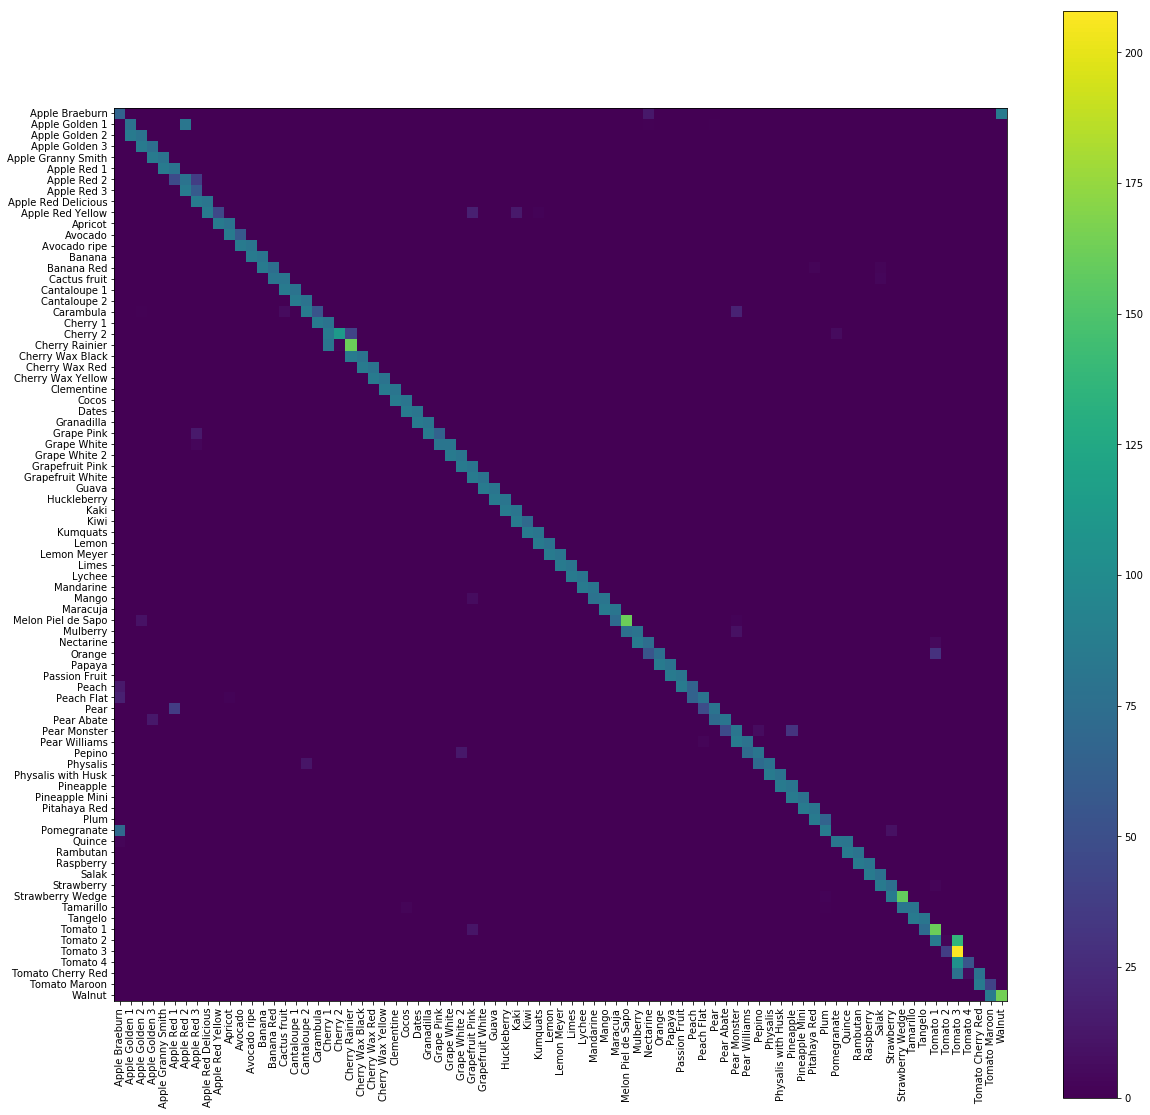

In [19]:
plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()

tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

### Testing our fruit classifier

In [21]:
from keras.preprocessing import image
import os
import cv2
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 32, 32


files = []
predictions = []
true_labels = []
# predicting images
for i in range(0, 10):
    path = 'fruits-360/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

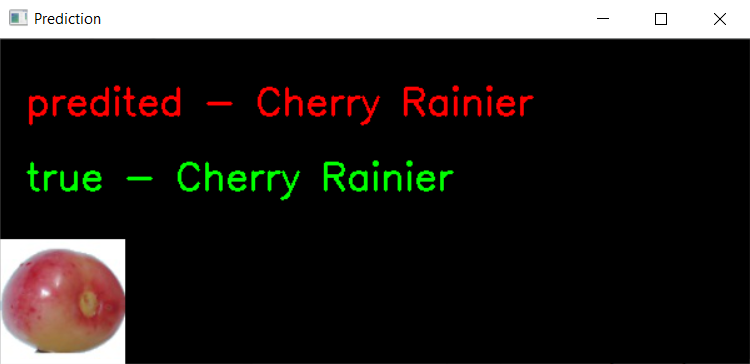

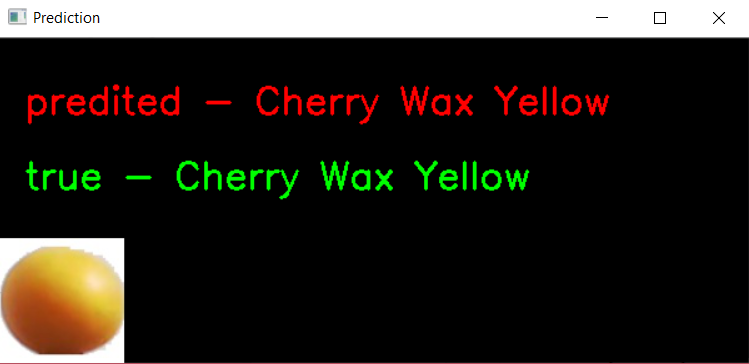

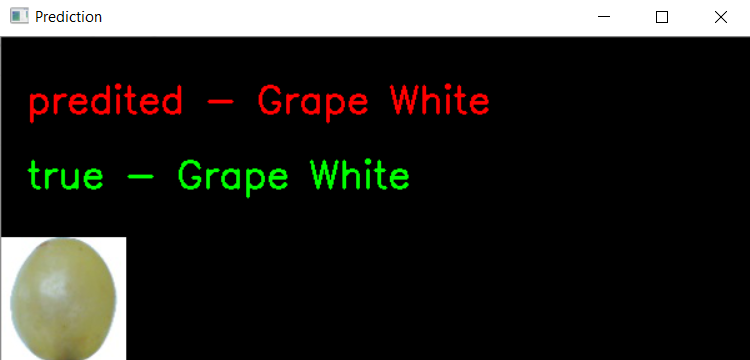

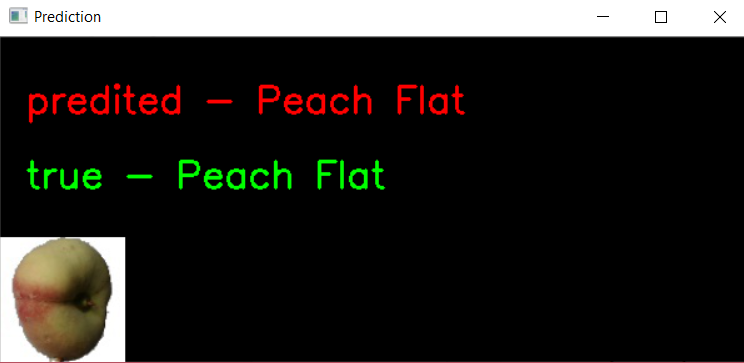

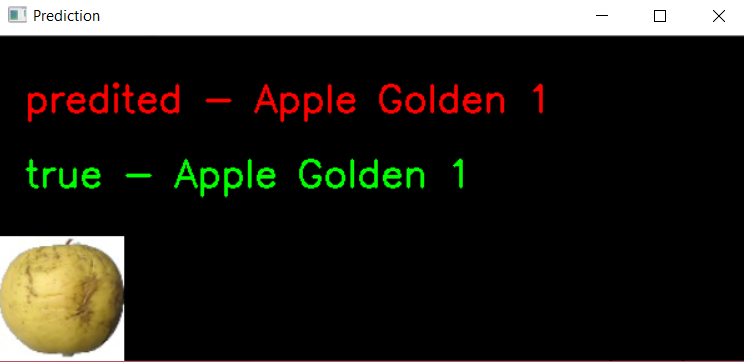

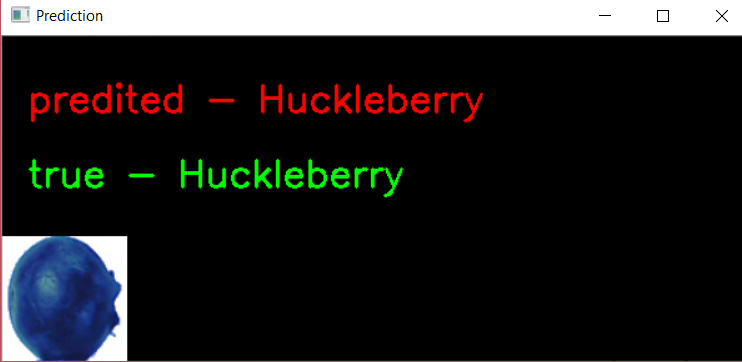

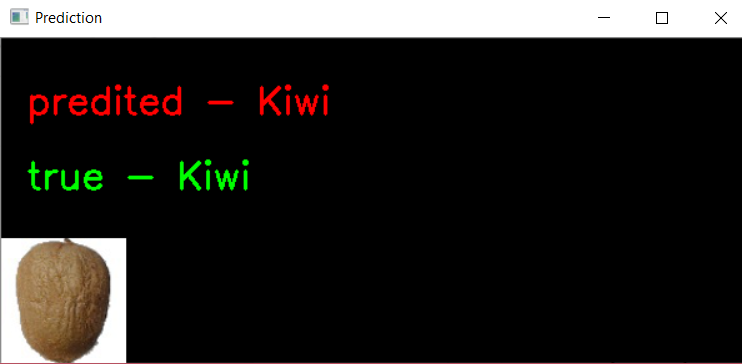